In [ ]:
## Imports Library

import os
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import random
from pathlib import Path
from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflowjs as tfjs

In [2]:
# DATASET PATH
img_path = '/Users/bimaaristo/Documents/College/Academics/Coding/POSTECH/Multiclass-Pill-Classification/dataset' 

In [3]:
# CLASS DISTRIBUTION FUNCTION

## TRAIN
def train_class(base_path):
    # Get class names from train folder 
    train_path = os.path.join(base_path, 'train')
    class_names = sorted([d for d in os.listdir(train_path) 
                         if os.path.isdir(os.path.join(train_path, d))])
    return class_names

def train_image_paths(base_path, subset='train'):
    # Get all image paths from the specified subset (train/validation)
    subset_path = os.path.join(base_path, subset)
    image_paths = []

    for class_name in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_path):

            valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
            paths = [os.path.join(class_path, f) for f in os.listdir(class_path)
                    if f.lower().endswith(valid_extensions)]
            image_paths.extend(paths)
    
    return image_paths

# VALL
def val_class(base_path):
    # Get class names from validation folder 
    train_path = os.path.join(base_path, 'validation')
    class_names = sorted([d for d in os.listdir(train_path) 
                         if os.path.isdir(os.path.join(train_path, d))])
    return class_names

def val_image_paths(base_path, subset='validation'):
    # Get all image paths from the specified subset validation
    subset_path = os.path.join(base_path, subset)
    image_paths = []

    for class_name in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_path):

            valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
            paths = [os.path.join(class_path, f) for f in os.listdir(class_path)
                    if f.lower().endswith(valid_extensions)]
            image_paths.extend(paths)
    
    return image_paths

def display_random_images(image_paths, num_images=50, cols=10):
    # Display random images
    sample_paths = random.sample(image_paths, min(num_images, len(image_paths)))
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 2*rows))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)  
    axes = axes.flatten() if rows > 1 else [axes]
    
    for idx, (img_path, ax) in enumerate(zip(sample_paths, axes)):
        # Class Name
        class_name = Path(img_path).parent.name
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Class Name as a Title
        ax.set_title(class_name, fontsize=8, pad=2)  # Reduced padding
        ax.spines['top'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['right'].set_visible(True)
        
    for idx in range(len(sample_paths), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
def plot_training_history(history):
    # Get training history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Get number of epochs
    epochs_range = range(len(acc))
    
    # Create figure with two subplots
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='lower right')
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [5]:
# CLASS
print("Classes in the dataset:")
class_names = train_class(img_path)
for idx, class_name in enumerate(class_names, 1):
    print(f"{idx}. {class_name}")

Classes in the dataset:
1. Ascozin
2. Bioflu
3. Biogesic
4. Bonamine
5. Buscopan
6. DayZinc
7. Decolgen
8. Flanax
9. Imodium
10. Lactezin
11. Lagundi
12. Midol
13. Myra_E
14. Neurogen_E
15. Omeprazole
16. Rinityn
17. Rogin_E
18. Sinecod
19. Tempra
20. Tuseran



Training Set Images:


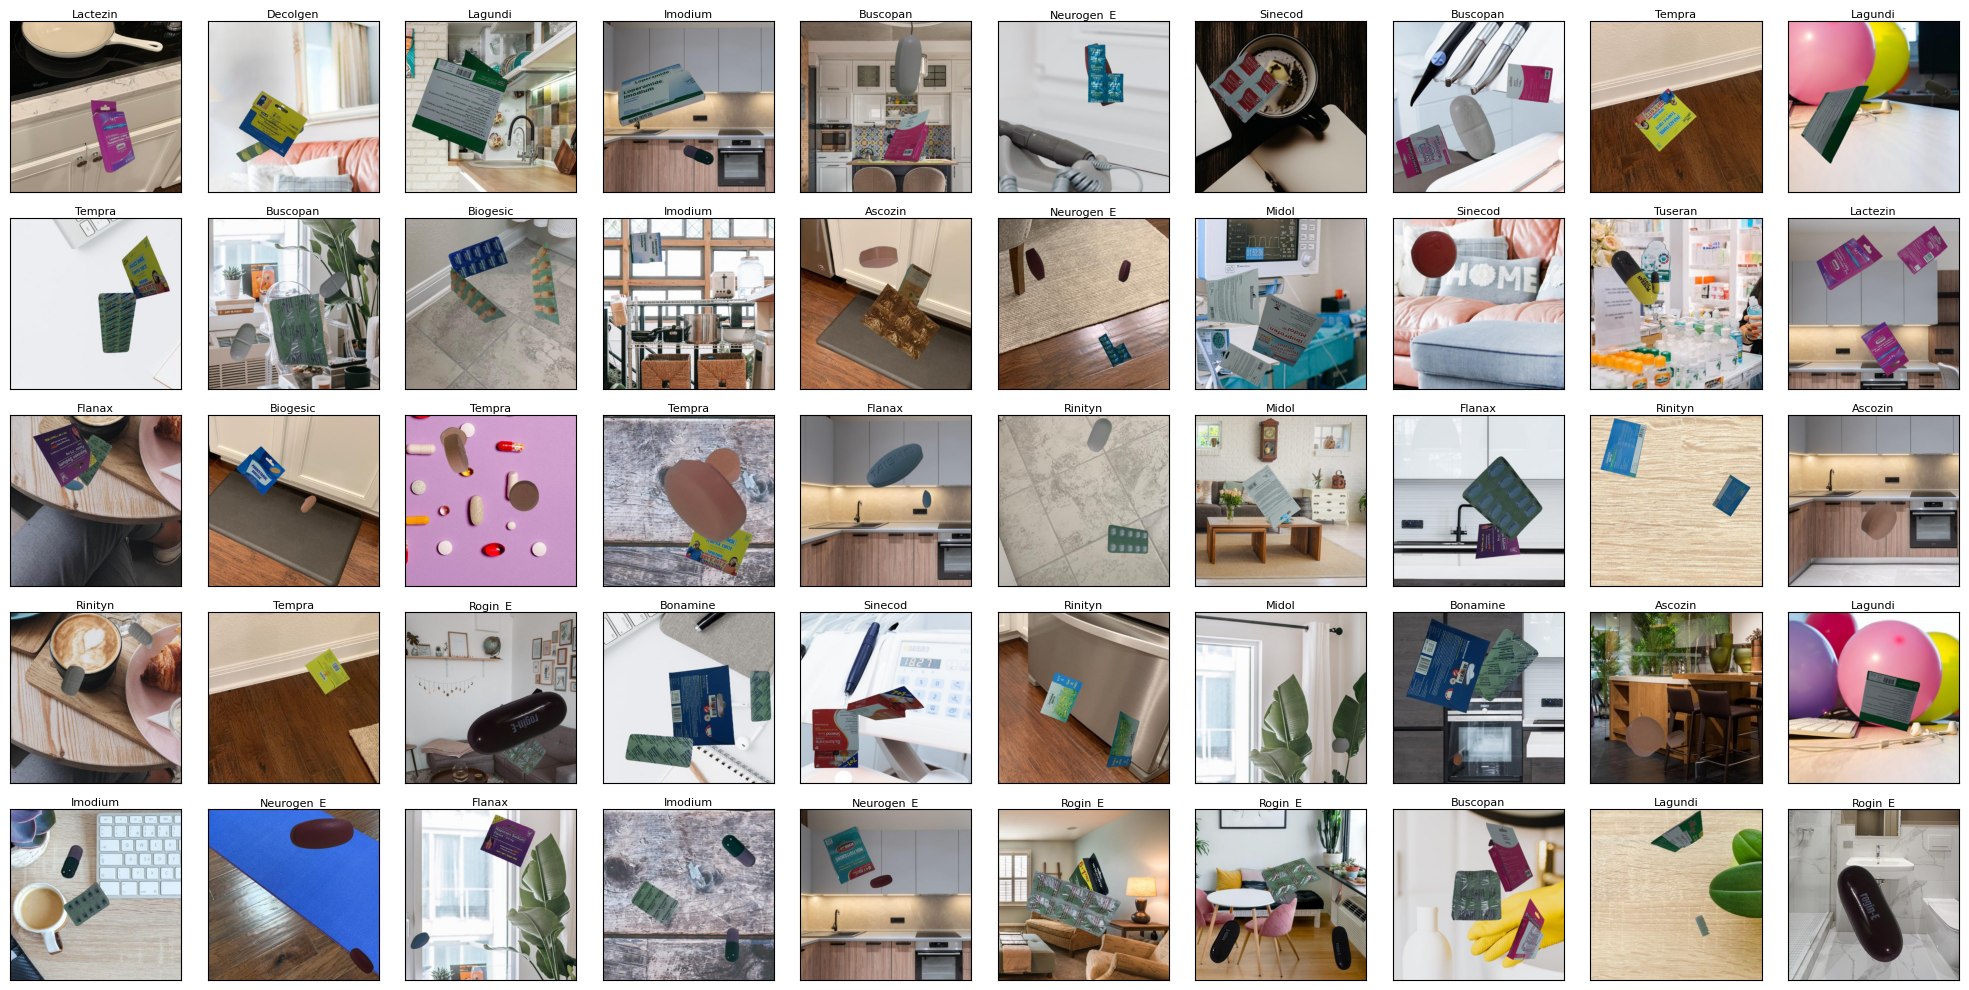

In [6]:
# DATASET
print("\nTraining Set Images:")
train_paths = train_image_paths(img_path)
display_random_images(train_paths, 50)

In [9]:
# Image size and batch size
train_path = '/Users/bimaaristo/Documents/College/Academics/Coding/POSTECH/Multiclass-Pill-Classification/dataset/Train'
val_path = '/Users/bimaaristo/Documents/College/Academics/Coding/POSTECH/Multiclass-Pill-Classification/dataset/Validation'

#data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=15,        
    width_shift_range=0.1,    
    height_shift_range=0.1,
    zoom_range=0.1,           
    horizontal_flip=True,
    brightness_range=[0.9,1.1], 
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 40000 images belonging to 20 classes.
Found 40000 images belonging to 20 classes.


In [10]:
# ResNet50 
base_model = applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# Freeze most of the layers
for layer in base_model.layers[:-30]: 
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(20, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0

In [11]:
#balanced class weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

In [12]:
# Compile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.96 and logs.get('val_accuracy')>0.96):
            print("\nDesired value is already achieved!")
            self.model.stop_training = True

In [14]:
# HISTORY
start_time = time.time()
callback = myCallback()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callback,
    epochs=20,
    verbose=1
)
end_time = time.time()
total_time = end_time - start_time
minutes = int(total_time // 60)
seconds = int(total_time % 60)

print(f"Training completed in {minutes} minutes and {seconds} seconds.")

Epoch 1/20
1250/1250 [==============================] - 661s 524ms/step - loss: 0.7702 - accuracy: 0.7976 - val_loss: 0.1854 - val_accuracy: 0.9502
Epoch 2/20
1250/1250 [==============================] - 721s 576ms/step - loss: 0.2314 - accuracy: 0.9417 - val_loss: 0.1189 - val_accuracy: 0.9676
Epoch 3/20
1250/1250 [==============================] - 646s 516ms/step - loss: 0.1660 - accuracy: 0.9567 - val_loss: 0.0902 - val_accuracy: 0.9746
Epoch 4/20
1250/1250 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.9622
Desired value is already achieved!
1250/1250 [==============================] - 688s 548ms/step - loss: 0.1396 - accuracy: 0.9622 - val_loss: 0.0825 - val_accuracy: 0.9773
Training completed in 45 minutes and 16 seconds.


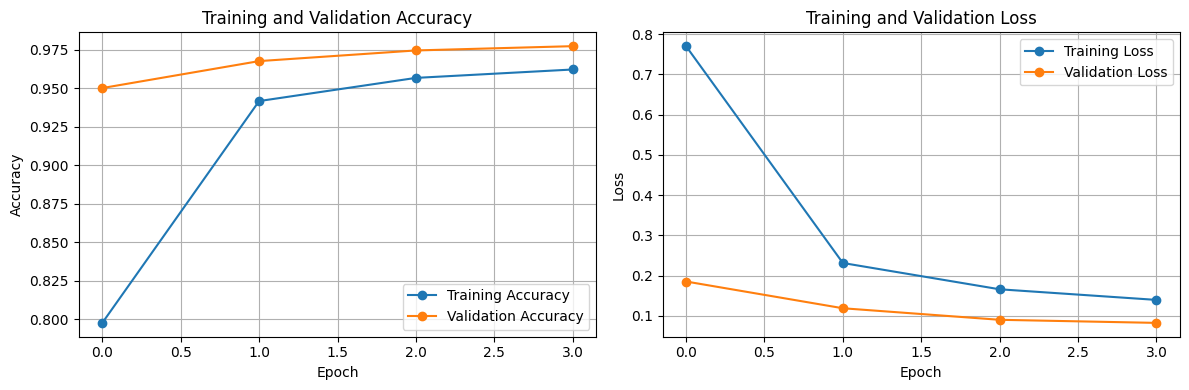

In [15]:
# Call the function after training
plot_training_history(history)

In [16]:
# Save the entire model to an HDF5 file
model.save("resnet50-model.h5")
print("Model saved as 'resnet50-model.h5'")

/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'resnet50-model.h5'


1/1 [==============================] - 3s 3s/step


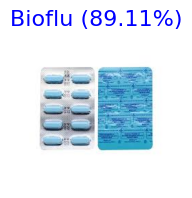

In [17]:
# # Load the saved model
model = load_model('/Users/bimaaristo/Documents/College/Academics/Coding/POSTECH/Multiclass-Pill-Classification/resnet50-model.h5')  

# Class labels (ensure these match your training setup)
class_labels = [
    "Ascozin", "Bioflu", "Biogesic", "Bonamine", "Buscopan", "DayZinc", 
    "Decolgen", "Flanax", "Imodium", "Lactezin", "Lagundi", "Midol", 
    "Myra_E", "Neurogen_E", "Omeprazole", "Rinityn", "Rogin_E", 
    "Sinecod", "Tempra", "Tuseran"
]

# Function to classify an image
def classify_image(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    # Predict using the model
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx] * 100

    # Output the class label and confidence
    predicted_class = class_labels[predicted_class_idx]
    return predicted_class, confidence, img

# Let the user input the image path
image_path = input("Enter the path to the image: ").strip()

if image_path:
    predicted_class, confidence, img = classify_image(image_path)

    # Display the image with prediction
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence:.2f}%)", fontsize=16, color='blue')
    plt.show()
else:
    print("No image path provided.")